<a href="https://colab.research.google.com/github/sejin1129/BenchMarking/blob/main/vgg16_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Files already downloaded and verified
Files already downloaded and verified
cuda:0
[1,  1563] loss: 2.374
[2,  1563] loss: 1.615
[3,  1563] loss: 1.277
[4,  1563] loss: 1.050
[5,  1563] loss: 0.899
[6,  1563] loss: 0.761
[7,  1563] loss: 0.649
[8,  1563] loss: 0.553
[9,  1563] loss: 0.466
[10,  1563] loss: 0.397
Finished Training
Accuracy for class: plane is 80.3 %
Accuracy for class: car   is 91.5 %
Accuracy for class: bird  is 54.1 %
Accuracy for class: cat   is 57.0 %
Accuracy for class: deer  is 85.3 %
Accuracy for class: dog   is 62.8 %
Accuracy for class: frog  is 82.2 %
Accuracy for class: horse is 85.0 %
Accuracy for class: ship  is 85.5 %
Accuracy for class: truck is 85.1 %


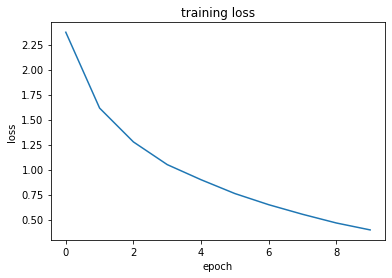

In [7]:
# 1. torchvision을 사용하여 CIFAR10을 불러오고 정규화 하기
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline

# Compose(), 여러 변환 작업을 단일 파이프라인으로 연결
transform = transforms.Compose(
    # ToTensor(), Python Image Library or Numpy 배열인 입력 이미지를 파이토치 텐서로 변환
    [transforms.ToTensor(),
     # 평균 및 표준 편차로 tensor 정규화, 각 채널의 평균값(RGB), 각 채널의 표준편차 값 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# 각 미니 배치에 32개의 샘플이 포함됨
batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        # transforms.Compose()를 사용하여 이전에 정의된 변환 파이프라인으로 설정
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          # num_workers : 데이터 로드에 사용할 하위 프로세스 수
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

## loss function의 y값을 위한 스택
loss_stack = []

# 2. torchvision.models로 vgg16 불러오기
model = torchvision.models.vgg16(pretrained=False)


## CUDA 기기가 존재한다면, CUDA 장치를 출력:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)


# 3. 손실 함수 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)


# 4. 학습용 데이터를 사용하여 신경망 학습
n = len(trainloader)
for epoch in range(10):   # 데이터셋을 수차례 반복합니다.
    loss_add = 0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
    #    inputs, labels = data # cuda 사용
        inputs, labels = data[0].to(device), data[1].to(device)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력
        running_loss += loss.item()
        if i % n == n-1:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / n:.3f}')
            loss_stack.append(running_loss / n)
            running_loss = 0.0

print('Finished Training')

# 5. loss - epoch 그래프 출력
plt.title("training loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(loss_stack)


# 학습한 모델 저장
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도 필요 없음
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')